Requirements

In [1]:
""" !pip install torchvision==0.8.2
!pip install timm==0.3.2
!pip install mmcv-full==1.2.7
!pip install opencv-python==4.5.1.48
!cd SegFormer && pip install -e . --user """

' !pip install torchvision==0.8.2\n!pip install timm==0.3.2\n!pip install mmcv-full==1.2.7\n!pip install opencv-python==4.5.1.48\n!cd SegFormer && pip install -e . --user '

In [1]:
config_path = 'local_configs/segformer/B5/segformer.b5.1024x1024.city.160k.py'
dataset_root = '/data/users_home/mbarin/cityscapes'
ckpt_path = '/home/mbarin/Desktop/vs-code/segformer/SegFormer/checkpoints/segformer.b5.1024x1024.city.160k.pth'

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model for Inference

In [4]:
import mmcv

/home/mbarin/anaconda3/envs/segformer_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cfg = mmcv.Config.fromfile(config_path)
cfg.model.pretrained = None
cfg.data.test.test_mode = True
cfg.model.train_cfg = None

In [6]:
from mmcv.utils import Registry, build_from_cfg
import argparse
import os

import mmcv
import torch
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from mmcv.utils import DictAction

from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from IPython import embed

In [7]:

model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))

In [8]:
checkpoint = load_checkpoint(model, ckpt_path, map_location='cpu')

Use load_from_local loader


### Data

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from cityscapes.dataset import Cityscapes
from easydict import EasyDict as edict

from torch.utils.data import DataLoader

In [13]:
hparams = edict(
            dataset_root=dataset_root
        )


In [14]:
transform = A.Compose([
    ToTensorV2()
])

In [15]:
dataset = Cityscapes(hparams=hparams,
                                    split='val',
                                    sampling_type='random',
                                    #distortion=distortion, 
                                    transform=transform,
                                    severity=str(1))

IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


In [16]:
img, target, path = dataset[0]

In [17]:
img.shape, target.shape, path

(torch.Size([3, 1024, 2048]),
 torch.Size([1024, 2048]),
 '/data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt/spatter/1/frankfurt_000000_000294_leftImg8bit.png')

In [18]:
import matplotlib.pyplot as plt
import numpy as np

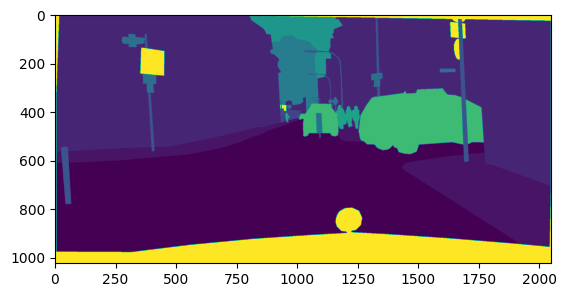

In [19]:
plt.imshow(target)

In [20]:
img, target, path = dataset[0]

In [21]:
img.shape

torch.Size([3, 1024, 2048])

In [22]:
img.dtype
model.cuda()
_ = model.eval()

In [32]:
with torch.no_grad():
    out = model([img.unsqueeze(0).cuda()*1.0], img_metas=[[{'ori_shape':[1024, 2048], 'img_shape':[1024,2048],  'pad_shape':[0,0,0,0], 'flip':False}]], return_loss=False)

out

[{'ori_shape': [1024, 2048], 'img_shape': [1024, 2048], 'pad_shape': [0, 0, 0, 0], 'flip': False}]


[array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

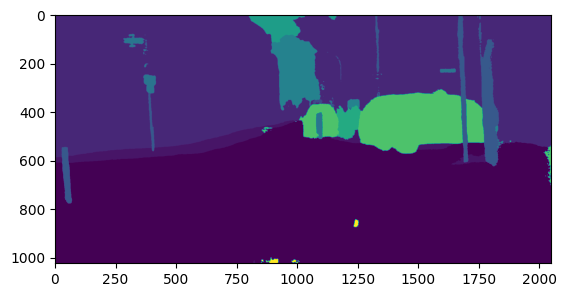

In [39]:
plt.imshow(out[0])

In [36]:
model = model.cuda()
with torch.no_grad():
            result = model.inference(torch.Tensor(img).permute(2, 0, 1).unsqueeze(0).cuda(), img_meta=[{'ori_shape':(1024,2048)}], rescale=False)

AssertionError: Default process group is not initialized

In [23]:
transform = A.Compose([
    A.Normalize(
        mean=np.array([123.675, 116.28, 103.53])/255.0,
        std=np.array([58.395, 57.12, 57.375])/255.0
        ),
    ToTensorV2()
])

In [24]:
d = Cityscapes(hparams=hparams,
    split='val',
    sampling_type='separate',
    distortion="spatter", 
    transform=transform,
    severity=str(1))

IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


In [25]:
for p in d.images:
    if 'leftImg8bit' not in p:
        print(p)

In [26]:
[p.split('/')[-3] for p in d.images]

['spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'spatter',
 'sp

In [27]:
img, lbl, _ = d[0]

print()

In [28]:
img.min(), img.max()

(tensor(-2.1179), tensor(2.6400))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


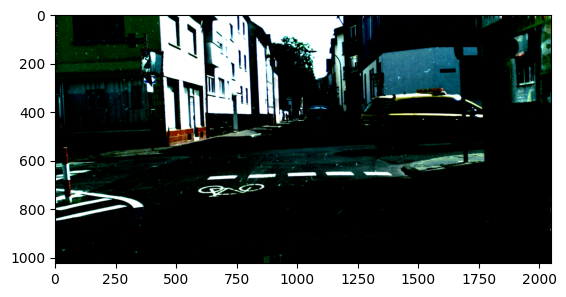

In [29]:
plt.imshow(img.permute(1,2,0))

In [30]:
from torchmetrics import JaccardIndex
import pickle

In [31]:
from tqdm import tqdm

In [83]:
NUM_RANDOM_SAMPLING = 5

random_iou_vals = edict()

model.cuda()
_ = model.eval()
for severity in range(1,6): 
    random_iou_vals[str(severity)] = edict()
    for R in range(NUM_RANDOM_SAMPLING):
        
        distorted_dataset = Cityscapes(hparams=hparams,
                                    split='val',
                                    sampling_type='random',
                                    #distortion=distortion, 
                                    transform=transform,
                                    severity=str(severity))
        
        distorted_dataloader = DataLoader(distorted_dataset, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            num_workers=4)

        metric = JaccardIndex(num_classes=20, ignore_index=19)

        for img, target, img_path  in tqdm(distorted_dataloader):  # img, target, img_path

            img_path = img_path[0]
            # img: Tensor,  distorted img of shape N X 1024 X 2048 X 3
            # target: Tensor,  of shape N X 1024 X 2048
            # img path: str 


            # model inference code

            with torch.no_grad():
                out = model([img.cuda()*1.0], img_metas=[[{'ori_shape':[1024, 2048], 'img_shape':[1024,2048],  'pad_shape':[0,0,0,0], 'flip':False}]], return_loss=False)
            
            pred = torch.from_numpy(out[0])

            metric.update(pred, target)

        random_iou_vals[str(severity)][f"trial_{R}"] = metric.compute()
        with open("random_robust.pkl", "wb") as f:
            pickle.dump(random_iou_vals, f)

        

IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:01<00:00,  1.32s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:06<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:08<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:06<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:08<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:06<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:11<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:12<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:12<00:00,  1.35s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:09<00:00,  1.34s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:20<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:29<00:00,  1.38s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:20<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:14<00:00,  1.35s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


 33%|███▎      | 164/500 [03:42<07:33,  1.35s/it]

In [32]:
distortions = d.distortions

In [33]:
distortions

['gaussian_noise',
 'shot_noise',
 'impulse_noise',
 'defocus_blur',
 'brightness',
 'contrast',
 'elastic_transform',
 'speckle_noise',
 'gaussian_blur',
 'spatter',
 'saturate']

In [43]:
all_iou_vals = edict()
for severity in [1]: 
    all_iou_vals[str(severity)] = edict()
    for dist in distortions:
        
        distorted_dataset = Cityscapes(hparams=hparams,
                                    split='val',
                                    sampling_type='separate',
                                    distortion=dist, 
                                    transform=transform,
                                    severity=str(severity))
        
        distorted_dataloader = DataLoader(distorted_dataset, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            num_workers=4)

        metric = JaccardIndex(num_classes=20, ignore_index=19)

        for img, target, img_path  in tqdm(distorted_dataloader):  # img, target, img_path

            img_path = img_path[0]
            # img: Tensor,  distorted img of shape N X 1024 X 2048 X 3
            # target: Tensor,  of shape N X 1024 X 2048
            # img path: str 


            # model inference code

            with torch.no_grad():
                out = model([img.cuda()*1.0], img_metas=[[{'ori_shape':[1024, 2048], 'img_shape':[1024,2048],  'pad_shape':[0,0,0,0], 'flip':False}]], return_loss=False)
            
            out = torch.from_numpy(out[0])

            metric.update(out, target)

        all_iou_vals[str(severity)][dist] = metric.compute()
        with open("all_robust_1.pkl", "wb") as f:
            pickle.dump(all_iou_vals, f)

IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:04<00:00,  1.33s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:18<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:21<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:22<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:19<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:21<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:18<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:17<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:19<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:19<00:00,  1.36s/it]


IMG DIR  /data/users_home/mbarin/cityscapes/leftImg8bit/val
TARGETS DIR  /data/users_home/mbarin/cityscapes/gtFine/val
THERE ARE 279 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/frankfurt
THERE ARE 186 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/munster
THERE ARE 71 files under this folder :  /data/users_home/mbarin/cityscapes/leftImg8bit/val/lindau
THERE ARE  500  IMAGES IN TOTAL


100%|██████████| 500/500 [11:18<00:00,  1.36s/it]


In [44]:
all_iou_vals

{'1': {'gaussian_noise': tensor(0.6728),
  'shot_noise': tensor(0.7056),
  'impulse_noise': tensor(0.6296),
  'defocus_blur': tensor(0.7791),
  'brightness': tensor(0.8127),
  'contrast': tensor(0.8096),
  'elastic_transform': tensor(0.5193),
  'speckle_noise': tensor(0.7591),
  'gaussian_blur': tensor(0.8095),
  'spatter': tensor(0.8068),
  'saturate': tensor(0.8109)}}

In [78]:
with open("test.pkl", "wb") as f:
            pickle.dump({"a":1}, f)

In [38]:
import pickle
with open('all_robust.pkl', 'rb') as f:
    x = pickle.load(f)


In [39]:
x

{'1': {'gaussian_noise': tensor(0.6728),
  'shot_noise': tensor(0.7056),
  'impulse_noise': tensor(0.6296),
  'defocus_blur': tensor(0.7791),
  'brightness': tensor(0.8127),
  'contrast': tensor(0.8096),
  'elastic_transform': tensor(0.5193),
  'speckle_noise': tensor(0.7591),
  'gaussian_blur': tensor(0.8095),
  'spatter': tensor(0.8068),
  'saturate': tensor(0.8109)},
 '2': {'gaussian_noise': tensor(0.5902)}}